# COVID-19 - ITALY - 2017-2019


## Initial setup and fetching data

In [50]:
import c19
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# sklearn as one of the most used machine learning package
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# statsmodels for statistics
import statsmodels.api as sm
from scipy import stats


# Fetch the Istat data
file_it_pop = 'data/Italy/italy_population_istat_2017-2019.csv'
pop = pd.read_csv(file_it_pop)


# Fetch COVID-19 data
url_c19 = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
c19df = pd.read_csv(url_c19)


## Pre-processing


In [2]:
# Preprocess the Istat dataset

# Replace Italian month names to corresponding numbers
pop['month'].replace(to_replace='Gennaio', value=1, inplace=True)
pop['month'].replace(to_replace='Febbraio', value=2, inplace=True)
pop['month'].replace(to_replace='Marzo', value=3, inplace=True)
pop['month'].replace(to_replace='Aprile', value=4, inplace=True)
pop['month'].replace(to_replace='Maggio', value=5, inplace=True)
pop['month'].replace(to_replace='Giugno', value=6, inplace=True)
pop['month'].replace(to_replace='Luglio', value=7, inplace=True)
pop['month'].replace(to_replace='Agosto', value=8, inplace=True)
pop['month'].replace(to_replace='Settembre', value=9, inplace=True)
pop['month'].replace(to_replace='Ottobre', value=10, inplace=True)
pop['month'].replace(to_replace='Novembre', value=11, inplace=True)
pop['month'].replace(to_replace='Dicembre', value=12, inplace=True)

# Create date as index
pop['date'] = pd.to_datetime(pop['year'].astype(str) + "-" + pop["month"].astype(str) + "-1")
pop.sort_values(by=['date'], inplace=True, ascending=True)
pop.set_index('date', inplace=True)

# Drop unused
pop.drop(columns=['territorial_variations','population_end', 'info'], inplace=True, errors="ignore")

In [3]:
pop.tail()


,year,month,population_start,births,deaths,sum_natural,registered,deleted,sum_migration
date,,,,,,,,,
2019-07-01,2019,7,60261833,39160,51507,-12347,149865,143336,6529
2019-08-01,2019,8,60256015,37953,49614,-11661,132524,123021,9503
2019-09-01,2019,9,60253857,38313,47267,-8954,145620,144111,1509
2019-10-01,2019,10,60246412,40917,52452,-11535,172516,163987,8529
2019-11-01,2019,11,60243406,35943,50865,-14922,152563,142525,10038


In [4]:
# Preprocess the COVID dataset

# Create a copy with the selected countries
c19_sel = c19df.loc[c19df['iso_code'].isin(['ITA'])].copy()

# Convert date column to datetime
c19_sel['date'] = pd.to_datetime(c19_sel['date'])

# Drop unused
c19_sel.drop(columns=['iso_code','location', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 
                      'new_deaths_per_million', 'tests_units'], inplace=True, errors="ignore")

# drop unique useless row from 2019-12-31
c19_sel = c19_sel.loc[c19_sel['date'] >= '2020']

# Create year and months columns
c19_sel['year'] = c19_sel['date'].dt.year
c19_sel['month'] = c19_sel['date'].dt.month
c19_sel['day'] = c19_sel['date'].dt.day

# Fix NaN values
c19_sel['total_tests'].fillna(0, inplace=True)
c19_sel['new_tests'].fillna(0, inplace=True)
c19_sel['total_tests_per_thousand'].fillna(0, inplace=True)
c19_sel['new_tests_per_thousand'].fillna(0, inplace=True)

# sort by date and create index
c19_sel.sort_values(by=['date'], inplace=True, ascending=True)
c19_sel.set_index('date', inplace=True)


c19_sel



,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,year,month,day
date,,,,,,,,,,,
2020-01-01,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,1
2020-01-02,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,2
2020-01-03,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,3
2020-01-04,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,4
2020-01-05,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,5
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826,2020,4,26
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529,2020,4,27
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947,2020,4,28


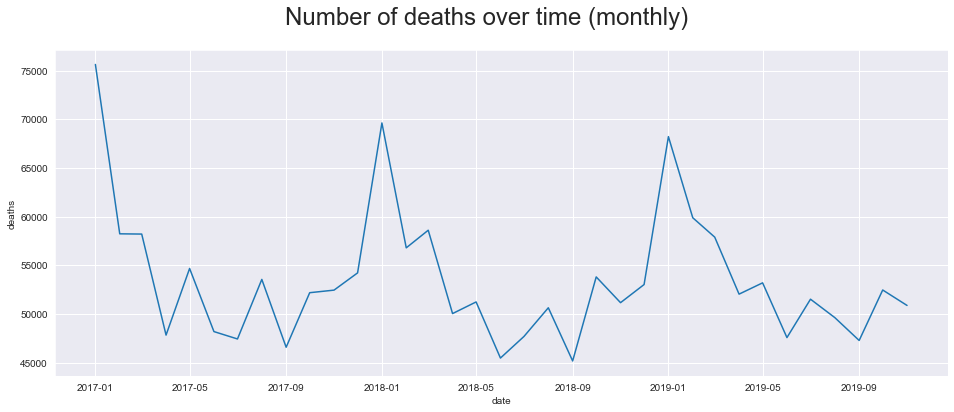

In [5]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
fig.suptitle('Number of deaths over time (monthly)', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x=pop.index, y="deaths", data=pop, ax=ax)


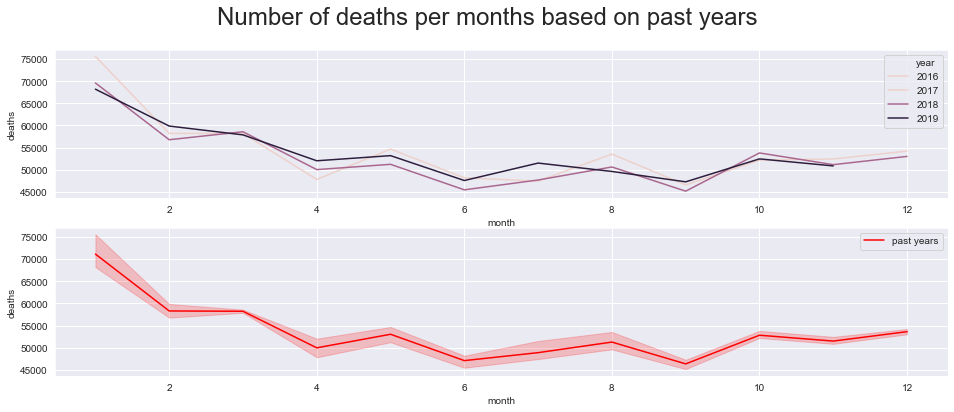

In [6]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=2, figsize=(16, 6))
fig.suptitle('Number of deaths per months based on past years', fontsize=24)

ax = axes[0]
ax.grid(b=True, which='major', color='w', linewidth=1.0)
sns.lineplot(x='month', y="deaths", hue='year', color="red", data=pop, ax=ax)

ax = axes[1]
ax.grid(b=True, which='major', color='w', linewidth=1.0)
sns.lineplot(x='month', y="deaths", color="red", label="past years", data=pop, ax=ax)


In [7]:
# Calculate a daily average number of deaths based on the previous years
avg_deaths = pop.groupby(["month"]).agg({'deaths': np.mean})
avg_deaths.reset_index(inplace = True, drop = False)
avg_deaths['days'] = [31,28,31,30,31,30,31,31,30,31,30,31]
avg_deaths['daily'] = avg_deaths['deaths'] / avg_deaths['days'] 

avg_deaths



,month,deaths,days,daily
0,1,71149.000000,31,2295.129032
1,2,58294.333333,28,2081.940476
2,3,58224.333333,31,1878.204301
3,4,49958.666667,30,1665.288889
4,5,53025.333333,31,1710.494624
5,6,47067.666667,30,1568.922222
6,7,48870.000000,31,1576.451613
7,8,51259.666667,31,1653.537634
8,9,46332.333333,30,1544.411111
9,10,52807.333333,31,1703.462366


(0, 2332.664928315412)

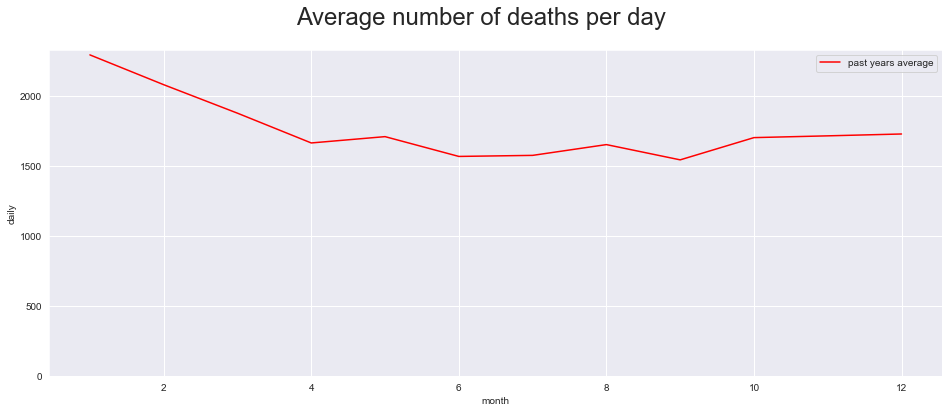

In [8]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 6))
fig.suptitle('Average number of deaths per day', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x='month', y="daily", markers=True, color="red", label="past years average", data=avg_deaths, ax=ax)
ax.set_ylim(ymin=0)


In [9]:
c19_sel

,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,year,month,day
date,,,,,,,,,,,
2020-01-01,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,1
2020-01-02,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,2
2020-01-03,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,3
2020-01-04,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,4
2020-01-05,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,5
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826,2020,4,26
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529,2020,4,27
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947,2020,4,28


In [10]:
c19_mrg = c19_sel.reset_index(inplace = False, drop = False)
c19_mrg = c19_mrg.merge(avg_deaths,how='left', left_on='month', right_on='month')
c19_mrg.set_index('date', inplace=True)
c19_mrg

,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,year,month,day,deaths,days,daily
date,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,1,71149.000000,31,2295.129032
2020-01-02,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,2,71149.000000,31,2295.129032
2020-01-03,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,3,71149.000000,31,2295.129032
2020-01-04,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,4,71149.000000,31,2295.129032
2020-01-05,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,5,71149.000000,31,2295.129032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826,2020,4,26,49958.666667,30,1665.288889
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529,2020,4,27,49958.666667,30,1665.288889
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947,2020,4,28,49958.666667,30,1665.288889


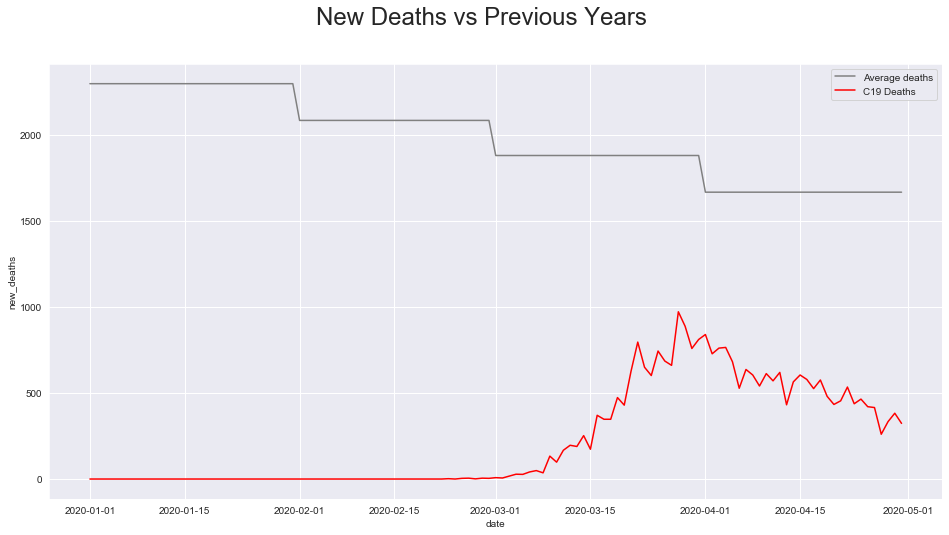

In [11]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 8))
fig.suptitle('New Deaths vs Previous Years', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x=c19_mrg.index, y="daily", color="gray", label="Average deaths", data=c19_mrg, ax=ax)
sns.lineplot(x=c19_mrg.index, y="new_deaths", color="red", label="C19 Deaths", data=c19_mrg, ax=ax)


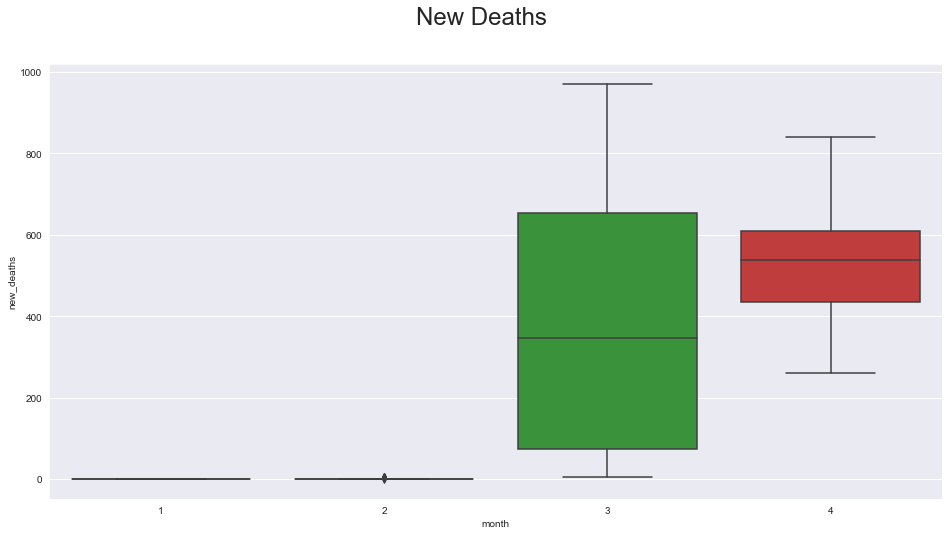

In [12]:
# Boxplot new deaths over the months
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 8))
fig.suptitle('New Deaths', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.boxplot(x=c19_mrg['month'], y="new_deaths", data=c19_mrg, ax=ax)
#sns.despine(offset=10, trim=True)


In [13]:
c19_mrg

,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,year,month,day,deaths,days,daily
date,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,1,71149.000000,31,2295.129032
2020-01-02,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,2,71149.000000,31,2295.129032
2020-01-03,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,3,71149.000000,31,2295.129032
2020-01-04,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,4,71149.000000,31,2295.129032
2020-01-05,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,5,71149.000000,31,2295.129032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826,2020,4,26,49958.666667,30,1665.288889
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529,2020,4,27,49958.666667,30,1665.288889
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947,2020,4,28,49958.666667,30,1665.288889


In [14]:

c19_mrg

,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,year,month,day,deaths,days,daily
date,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,1,71149.000000,31,2295.129032
2020-01-02,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,2,71149.000000,31,2295.129032
2020-01-03,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,3,71149.000000,31,2295.129032
2020-01-04,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,4,71149.000000,31,2295.129032
2020-01-05,0,0,0,0,0.0,0.0,0.000,0.000,2020,1,5,71149.000000,31,2295.129032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,195351,2357,26384,415,1757659.0,49916.0,29.071,0.826,2020,4,26,49958.666667,30,1665.288889
2020-04-27,197675,2324,26644,260,1789662.0,32003.0,29.600,0.529,2020,4,27,49958.666667,30,1665.288889
2020-04-28,199414,1739,26977,333,1846934.0,57272.0,30.547,0.947,2020,4,28,49958.666667,30,1665.288889


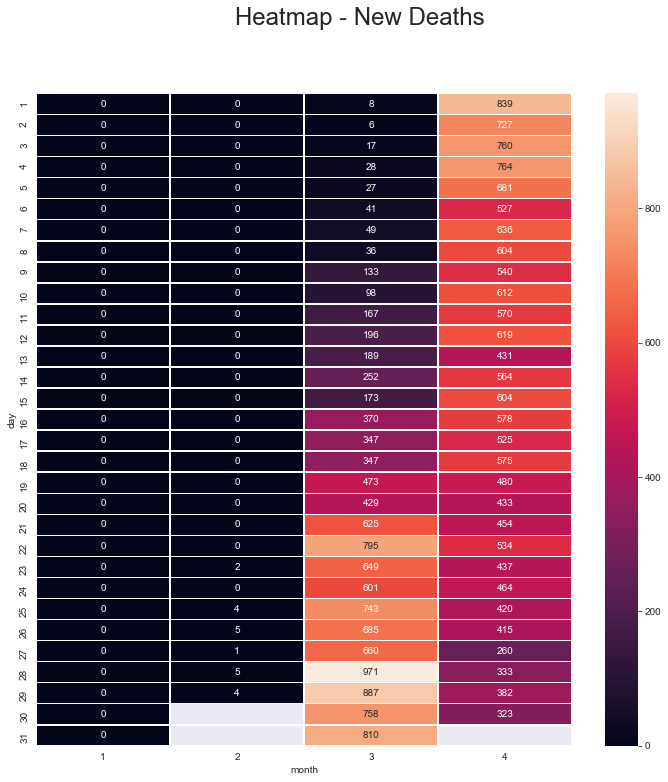

In [15]:
# Heatmap
deaths_table = c19_mrg.pivot("day", "month", "new_deaths")

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(12, 12))
fig.suptitle('Heatmap - New Deaths', fontsize=24)

ax = axes
sns.heatmap(deaths_table, annot=True, fmt="n", linewidths=.5, ax=ax)


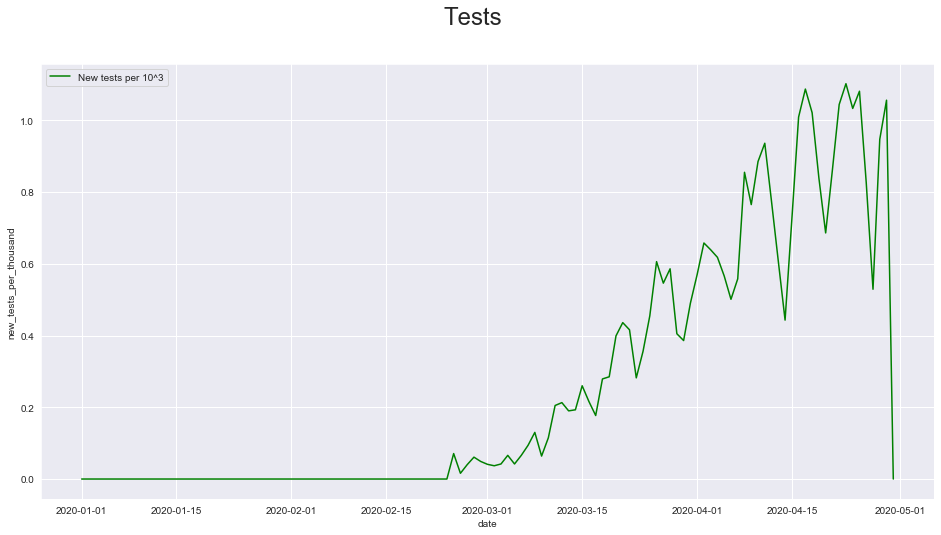

In [16]:
# Tests
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, figsize=(16, 8))
fig.suptitle('New Tests', fontsize=24)

ax = axes
ax.grid(b=True, which='major', color='w', linewidth=1.0)

sns.lineplot(x=c19_mrg.index, y="new_tests_per_thousand", color="green", label="New tests per 10^3", data=c19_mrg, ax=ax)

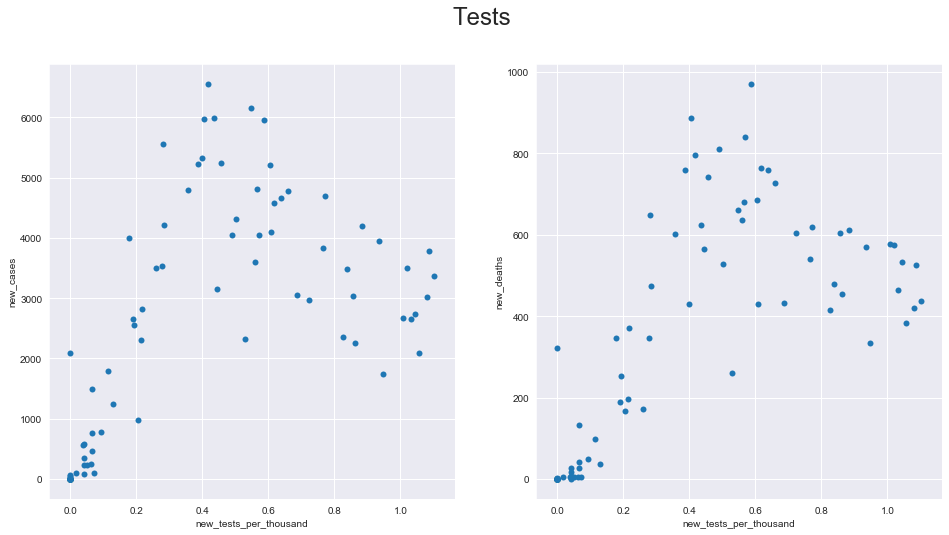

In [17]:
# Scatterplot tests vs cases/deaths
sns.set_style("dark")
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
fig.suptitle('New Tests vs New Cases / New Deaths', fontsize=24)

ax = axes[0]
ax.grid(b=True, which='major', color='w', linewidth=1.0)
sns.scatterplot(x="new_tests_per_thousand", y="new_cases", sizes=(1, 8), linewidth=0, data=c19_mrg, ax=ax)

ax = axes[1]
ax.grid(b=True, which='major', color='w', linewidth=1.0)
sns.scatterplot(x="new_tests_per_thousand", y="new_deaths", sizes=(1, 8), linewidth=0, data=c19_mrg, ax=ax)


In [18]:
# Other
#'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_tests',
#'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
#'year', 'month', 'day', 'deaths', 'days', 'daily'




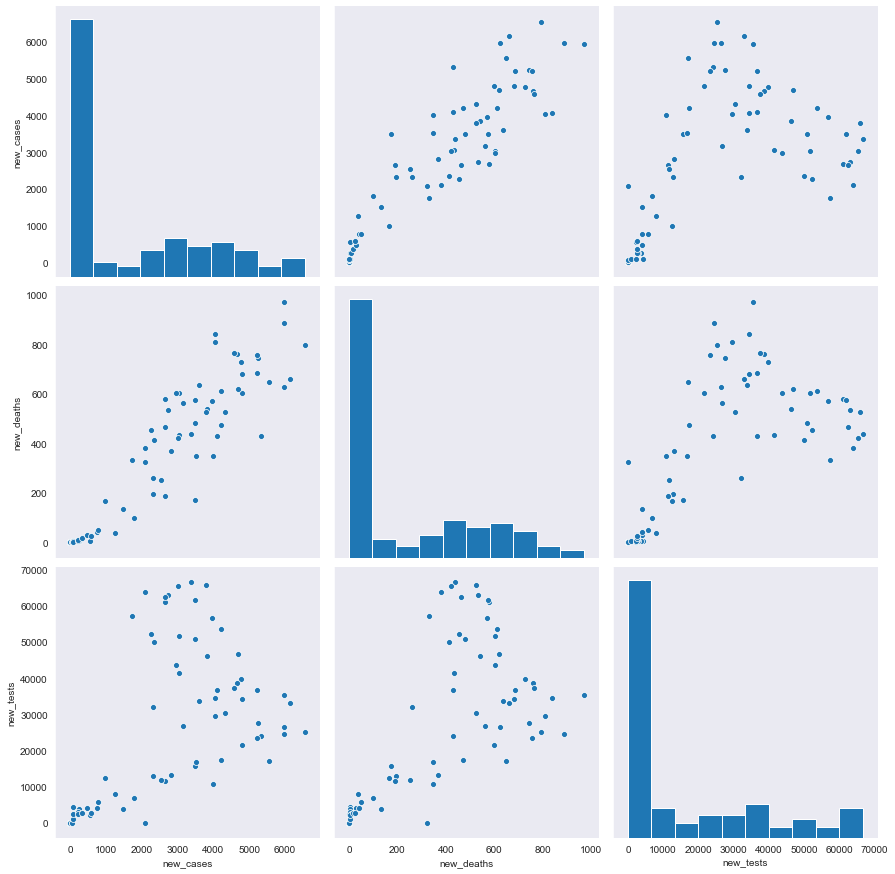

In [34]:
c19_small = c19_mrg.loc[:, c19_mrg.columns.isin(['new_cases','new_deaths','new_tests'])]
sns.pairplot(data=c19_small, height=4)
#plt.show()

In [35]:
# Linear Regression: new_cases -> new_deaths
X = c19_mrg['new_cases'].values.reshape(-1, 1)
y = c19_mrg['new_deaths'].values

model = LinearRegression()
model.fit(X,y)

score = round(model.score(X,y),4)
coeficient = model.coef_[0]
intercept = model.intercept_
print("The model has R^2:{}, for y={}x+{}".format(score, coeficient, intercept))


The model has R^2:0.9041, for y=0.1363022804620963x+-0.5613023269309849


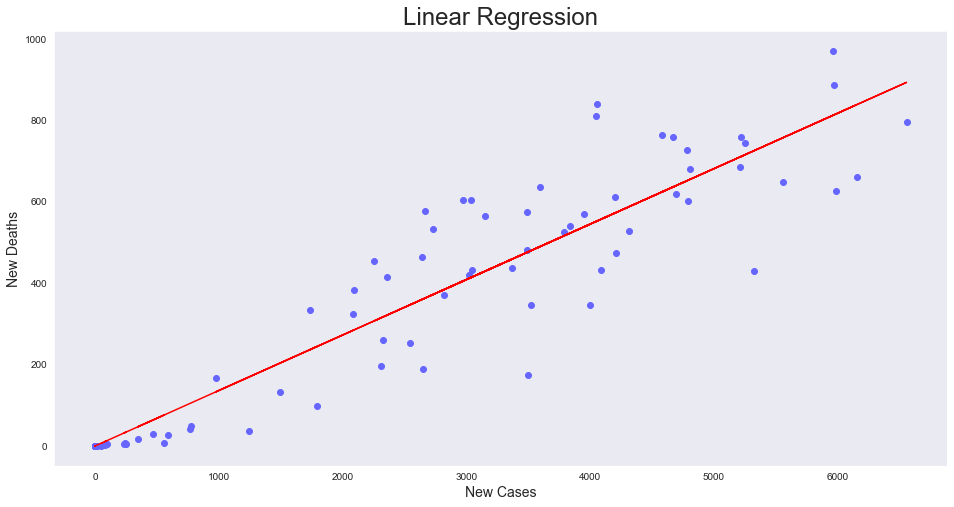

In [48]:
# Plot
plt.figure(figsize=(16,8)) 
plt.scatter(X, y, color='#6666ff')
plt.plot(X, model.predict(X), color= 'red')

plt.title('Linear Regression', fontsize=24)
plt.xlabel('New Cases', fontsize=14)
plt.ylabel('New Deaths', fontsize=14)

plt.show()

In [54]:
# create the ols model from statsmodel
X = c19_mrg['new_cases'].values.reshape(-1, 1)
y = c19_mrg['new_deaths'].values

#model_ols = sm.OLS(endog = y, exog = X).fit()

Xext = sm.add_constant(X)
model_ols = sm.OLS(endog = y, exog = Xext).fit()


model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1122.
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           2.04e-62
Time:                        16:41:07   Log-Likelihood:                -715.38
No. Observations:                 121   AIC:                             1435.
Df Residuals:                     119   BIC:                             1440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5613     10.681     -0.053      0.958     -21.711      20.588
x1             0.1363      0.004     33.490      0.000       0.128       0.144
==============================================================================
Omnibus:                       11.665   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               32.854
Skew:                          -0.037   Prob(JB):                     7.34e-08
Kurtosis:                       5.552   Cond. No.                     3.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

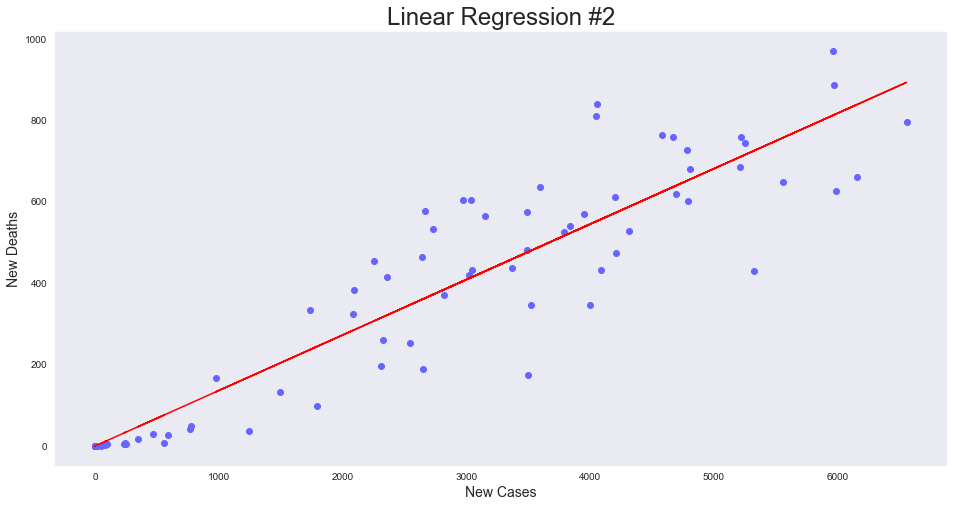

In [55]:
# Plot
plt.figure(figsize=(16,8))
plt.scatter(X, y, color='#6666ff')
plt.plot(X, model_ols.predict(Xext), color= 'red')

plt.title('Linear Regression #2', fontsize=24)
plt.xlabel('New Cases', fontsize=14)
plt.ylabel('New Deaths', fontsize=14)

plt.show()

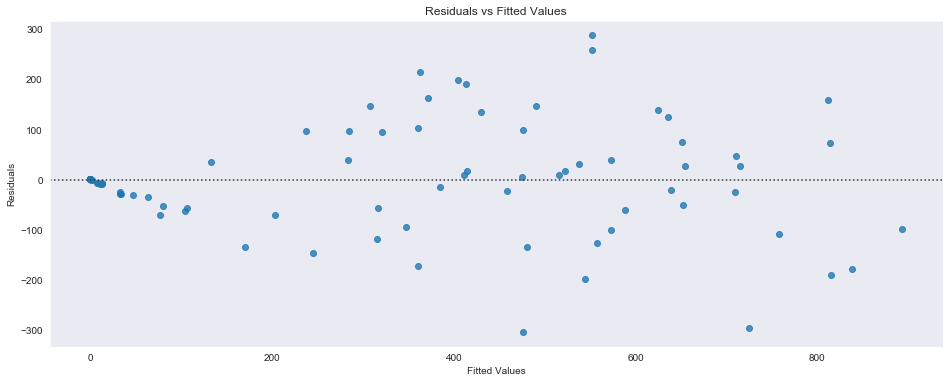

In [58]:
# get the model's residuals
model_ols_residuals = model_ols.resid

# get the fitted values
model_ols_y = model_ols.fittedvalues

# defining a figure size, so people in the back can see it as well
plt.figure(figsize=(16,6))

ax = sns.residplot(model_ols_y, model_ols_residuals)

ax.set_title('Residuals vs Fitted Values')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

plt.show()


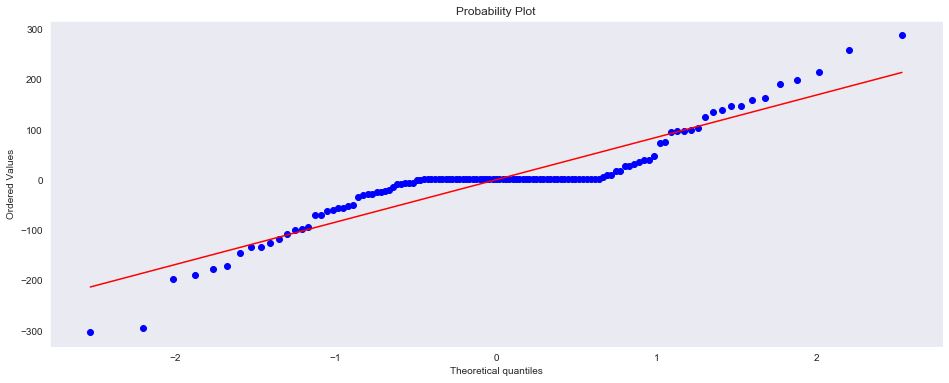

In [59]:
# QQPlot
plt.figure(figsize=(16,6))
QQ = stats.probplot(model_ols_residuals, dist = 'norm', plot = plt)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html



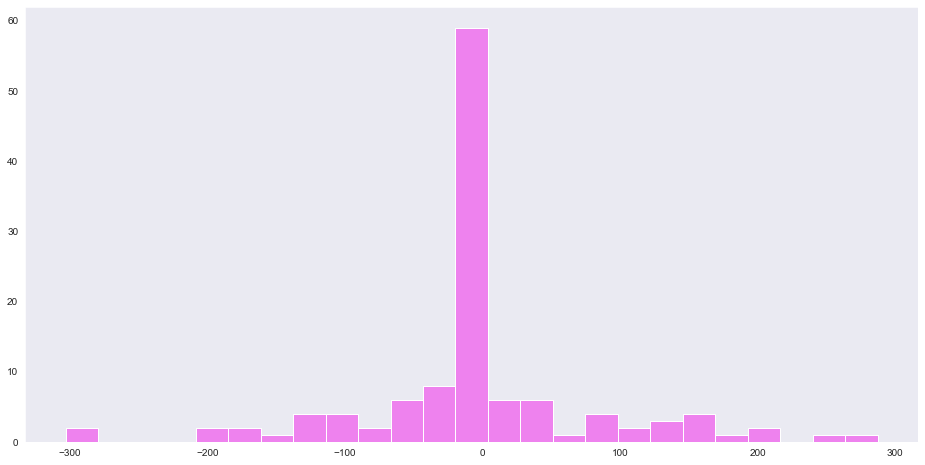

In [61]:
# Histogram
plt.figure(figsize=(16,8))
plt.hist(model_ols_residuals, density = False, bins = 25, color = 'violet')
plt.show()
